In [515]:
%%time
import sys; sys.path.insert(0, '..') # add parent folder path where discrepancies folder is

from discrepancies import datasets, pool, pool2graph, evaluation, discrepancies_intervals
from sklearn.metrics import recall_score, f1_score

import numpy as np
import pandas as pd

from matplotlib imporst pyplot as plt


X_train, X_test, y_train, y_test, _, _, _ = datasets.get_dataset(dataset='boston', n_samples=500, noise=0.3)
#pool1 = pool.AutogluonPool(max_delta_accuracies=0.05)
pool1 = pool.BasicPool()
pool1 = pool1.fit(X_train, y_train)
#print('F1 on Xtest', pool1.predict(X_test).apply(lambda x: f1_score(y_test, x)))
print('Discrepancy percentage', pool1.predict_discrepancies(X_train).mean())


p2g = pool2graph.pool2graph(X_train, y_train, pool1, k_init=20)

p2g.fit(max_epochs=5)




Discrepancy percentage 0.2359882005899705
CPU times: user 1.75 s, sys: 17.2 ms, total: 1.77 s
Wall time: 1.77 s


In [516]:
intervals = discrepancies_intervals.get_discrepancies_intervals(p2g.G)
len(intervals)

4277

In [517]:
global_interval_coord = []
for di in intervals:
    interval_coord = np.array((di.border_features.iloc[0] - di.border_features.iloc[1]).abs())
    global_interval_coord.append(interval_coord)
global_interval_coord = np.array(global_interval_coord)
global_interval_coord = pd.DataFrame(global_interval_coord, columns = X_train.columns)

In [257]:
global_interval_coord.mean()

CRIM       0.214276
ZN         0.413913
INDUS      0.514222
CHAS       0.207029
NOX        0.490571
RM         0.588728
AGE        0.579724
DIS        0.550825
RAD        0.336309
TAX        0.427452
PTRATIO    0.540766
B          0.221096
LSTAT      0.537741
dtype: float64

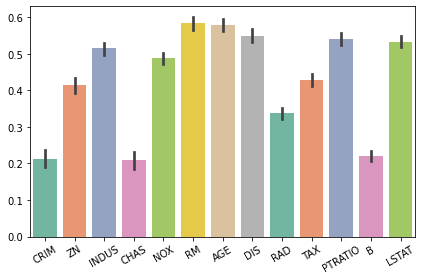

In [518]:
sns.set_style()


ax = sns.barplot(data=global_interval_coord, ci=95, palette="Set2")
ax.set_xticklabels(X_train.columns,rotation=30)

plt.tight_layout()
#plt.savefig("./../../results/results_boston_aggregated.pdf")


In [527]:
X_train.shape

(339, 13)

## Clustering

In [519]:
oneborder = np.array([di.border_features.iloc[0] for di in intervals])
coord_intervals = []
for di in intervals:
    a, b = di.border_features.iloc[0], di.border_features.iloc[1]
    if a[0] > 0:
        interval_coord = a - b
    else:
        interval_coord = a - b
    coord_intervals.append(interval_coord)
coord_intervals = np.array(coord_intervals)
coord_intervals = pd.DataFrame(coord_intervals, columns=X_train.columns)

nodes = p2g.get_nodes_attributes(p2g.get_nodes(discrepancies=True))[0]

In [506]:
nodes.mean()

CRIM      -0.044818
ZN         0.105184
INDUS     -0.056736
CHAS       0.156568
NOX       -0.049689
RM         0.045370
AGE       -0.116497
DIS        0.135174
RAD       -0.130270
TAX       -0.123632
PTRATIO   -0.249353
B          0.020121
LSTAT     -0.144699
dtype: float64

In [520]:
from sklearn.cluster import DBSCAN

clusters_onecoord = DBSCAN(eps=3.0, n_jobs=-1).fit_predict(oneborder)
clusters_coordint = DBSCAN(eps=4.0, n_jobs=-1).fit_predict(coord_intervals)
clusters_both = DBSCAN(eps=5.0, n_jobs=-1).fit_predict(np.append(oneborder, coord_intervals, axis=1))
clusters_nodes = DBSCAN(eps=1.5, min_samples=10, n_jobs=-1).fit_predict(nodes)
print(len(set(clusters_onecoord)), len(set(clusters_coordint)), len(set(clusters_both)), len(set(clusters_nodes)))

3 4 5 4


In [521]:
from sklearn.cluster import KMeans

clusters_onecoord = KMeans(n_clusters=5, n_jobs=-1).fit_predict(oneborder)
clusters_coordint = KMeans(n_clusters=4, n_jobs=-1).fit_predict(coord_intervals)
clusters_both = KMeans(n_clusters=5, n_jobs=-1).fit_predict(np.append(oneborder, coord_intervals, axis=1))
clusters_nodes = KMeans(n_clusters=5, n_jobs=-1).fit_predict(nodes)



             mean  count
cluster                 
0        0.392727     46
1       -0.278398    172
2        0.177089    174
3        0.240430    437
4        0.214189    369


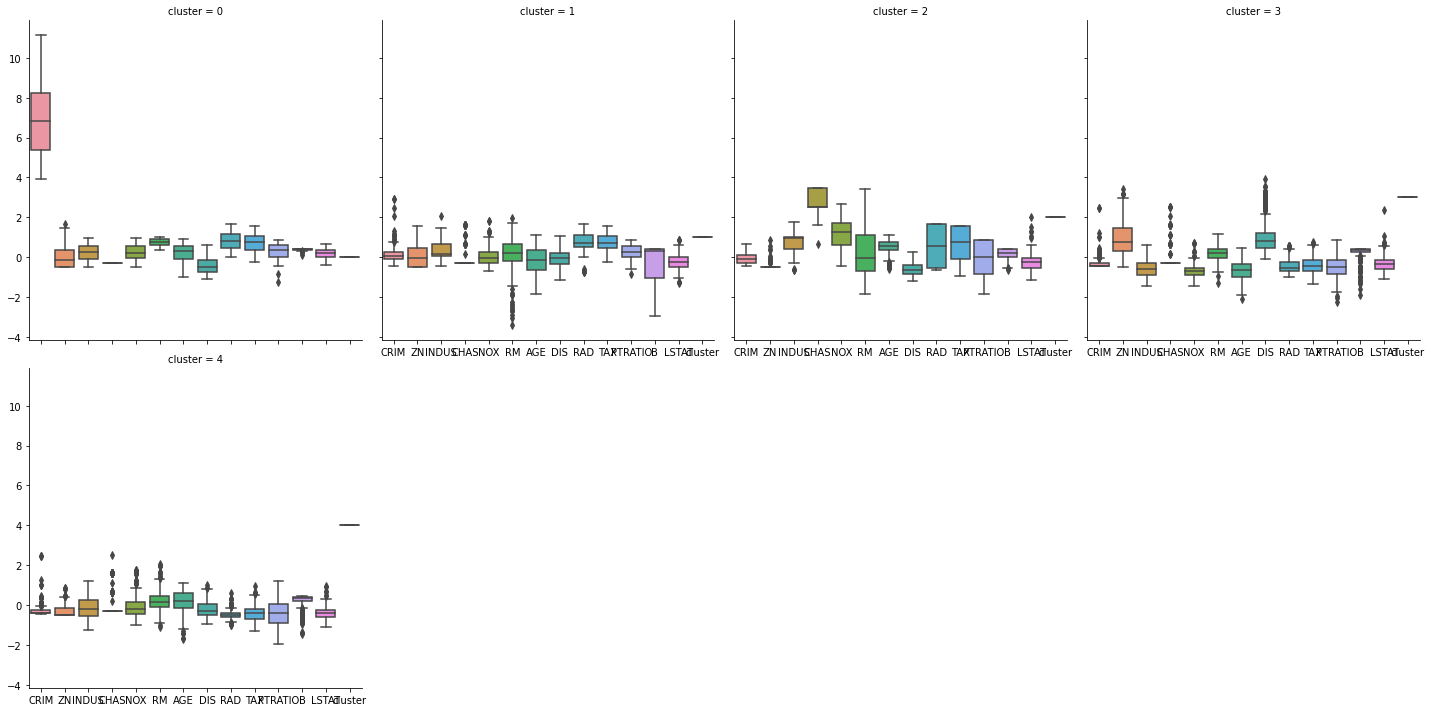

In [522]:
clusters = clusters_nodes.copy()
data = nodes.copy()


data["cluster"] = clusters
print(data.groupby("cluster").agg(['mean', 'count'])["B"])


sns.catplot(data=data, col="cluster", kind="box", col_wrap=4)

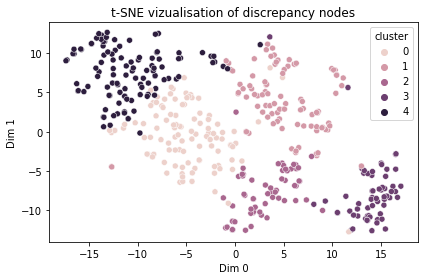

In [511]:
from sklearn.manifold import TSNE
#del data["cluster"]
tsne = TSNE(perplexity=50, n_jobs=-1).fit_transform(data)
tsne = pd.DataFrame(tsne, columns=["Dim 0", "Dim 1"])
tsne["cluster"] = clusters
sns.scatterplot(x="Dim 0", y="Dim 1", hue="cluster", data=tsne)
plt.title("t-SNE vizualisation of discrepancy nodes")
plt.tight_layout()
#plt.savefig("./../../results/discussion_tsne_boston.pdf")

In [451]:
# investigation on cluster CRIM
nodes_crim = nodes_c[nodes_c.cluster == 3]


TypeError: get_edge_data() missing 1 required positional argument: 'v'

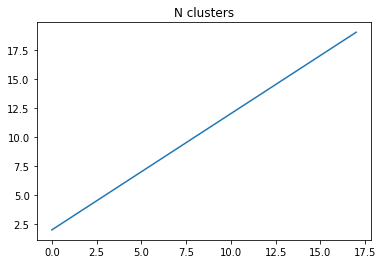

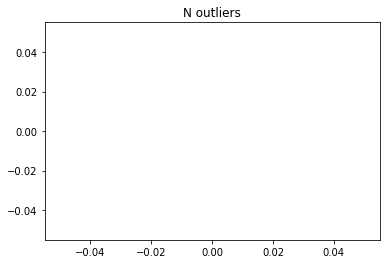

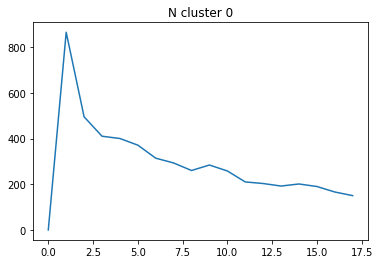

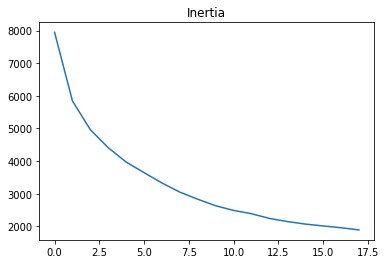

In [306]:
n_c = []
n_o = []
n_bc = [] # n biggest cluster
inertia_ = []
#for eps in [0.1, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]:
for k in range(2, 20):
    #clusters = DBSCAN(eps=eps, min_samples=5, n_jobs=-1).fit_predict(nodes)
    km = KMeans(n_clusters=k, n_jobs=-1)
    clusters = km.fit_predict(nodes)
    inertia_.append(km.inertia_)
    n_c.append(len(set(clusters)))
    #n_o.append((clusters == -1).sum())
    n_bc.append(np.array([(clusters == i).sum() for i in range(clusters.max())]).max() - np.array([(clusters == i).sum() for i in range(clusters.max())]).min())
plt.title("N clusters")
plt.plot(np.array(n_c))
plt.show()
plt.title("N outliers")
plt.plot(np.array(n_o))
plt.show()
plt.title("N cluster 0")
plt.plot(np.array(n_bc))
plt.show()
plt.title("Inertia")
plt.plot(np.array(inertia_))


TypeError: list indices must be integers or slices, not str

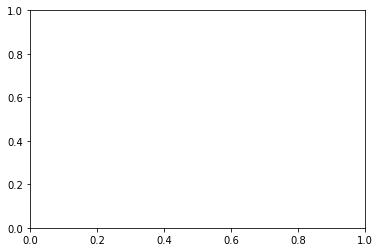

In [31]:
is_pred = pool1.predict_discrepancies(X_test)
ix = np.random.choice(X_test[is_pred == 1].index)
obs_to_interprete = X_test.loc[ix]
print(ix)
K_INTERVALS = 3
min_ = 9999
for di in intervals:
    
    if di.get_min_dist_to_point(obs_to_interprete) < min_:
        closest_interval = di
print(closest_interval.get_min_dist_to_point(obs_to_interprete))




In [250]:
len(p2g.G.nodes)

537